# Measuring Convergence

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In order to see whether our methods are working as designed, we need to be able to measure the convergence rate.  

With the ODE orbit problem, we had a single point (the current position of Earth) at the end of our integration.  Now we have $N$ points at the new time.  So we need to define a metric that allows us to quantify the error.

We'll define a [vector norm](https://en.wikipedia.org/wiki/Norm_(mathematics)), the $L_2$ norm, for a set of discrete data $\phi_i$, as:

$$\|\phi\|_2 = \left ( \Delta x \sum_{i=0}^{N-1} \phi_i^2 \right )^{1/2}$$

and then we can define an error as $e_i = a_i - a^\mathrm{exact}(x_i)$ for all the points in our domain and compute an error, $\epsilon$ as $\| e\|_2$.  

Further, for our problem, after 1 period, we know that the exact solution is just the initial data, so we can write:

$$\epsilon = \| a_i^\mathrm{final} - a_i^\mathrm{initial} \|_2
   = \left ( \Delta x \sum_{i=0}^{N-1} (a_i^\mathrm{final} - a_i^\mathrm{initial} )^2 \right )^{1/2}$$

```{important}   
It only makes sense to discuss convergence if the initial conditions themselves converge.  For the top hat, there is a discontinuity, and as we increase and increase the resolution, we will never resolve the step.  So the top hat is not a good set of initial conditions to assess convergence.  We should use a smooth problem.
```

## Upwind convergence

Let's compute the $L_2$ norm of the error for our upwind method.  In order for it to make sense, we need to use smooth data, so pick the initial conditions as:

$$a(x, t=0) = 1 + \frac{1}{2} \sin(2\pi x)$$
    
Now vary the number of grid points and measure the error and estimate the rate at which it converges.

We'll copy our grid class and upwind advection solver here

In [2]:
class FDGrid:
    """a finite-difference grid"""

    def __init__(self, nx, ng=1, xmin=0.0, xmax=1.0):
        """create a grid with nx points, ng ghost points (on each end)
        that runs from [xmin, xmax]"""

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords
        self.dx = (xmax - xmin)/(nx-1)
        self.x = xmin + (np.arange(nx+2*ng)-ng)*self.dx

        # storage for the solution
        self.a = self.scratch_array()
        self.ainit = self.scratch_array()
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]
        
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.x[self.ilo:self.ihi+1], self.ainit[self.ilo:self.ihi+1],
                label="initial conditions")
        ax.plot(self.x[self.ilo:self.ihi+1], self.a[self.ilo:self.ihi+1])
        ax.legend()
        return fig

In [3]:
def upwind_advection(nx, u, C, num_periods=1.0, init_cond=None):
    """solve the linear advection equation using FTCS.  You are required
    to pass in a function f(g), where g is a FDGrid object that sets up
    the initial conditions"""
    
    g = FDGrid(nx)
    
    # time info
    dt = C*g.dx/u
    t = 0.0
    tmax = num_periods*(g.xmax - g.xmin)/u

    # initialize the data
    init_cond(g)

    g.ainit[:] = g.a[:]
    
    # evolution loop
    anew = g.scratch_array()

    while t < tmax:

        if t + dt > tmax:
            dt = tmax - t
            C = u*dt/g.dx

        # fill the boundary conditions
        g.fill_BCs()

        # loop over zones: note since we are periodic and both endpoints
        # are on the computational domain boundary, we don't have to
        # update both g.ilo and g.ihi -- we could set them equal instead.
        # But this is more general
        for i in range(g.ilo, g.ihi+1):
            anew[i] = g.a[i] - C*(g.a[i] - g.a[i-1])

        # store the updated solution
        g.a[:] = anew[:]
        
        t += dt
        
    return g

And here are our initial conditions

In [4]:
def sine(g):
    g.a[:] = 1.0 + 0.5 * np.sin(2.0*np.pi*g.x)

In [5]:
C = 0.5
u = 1.0
nx = 128

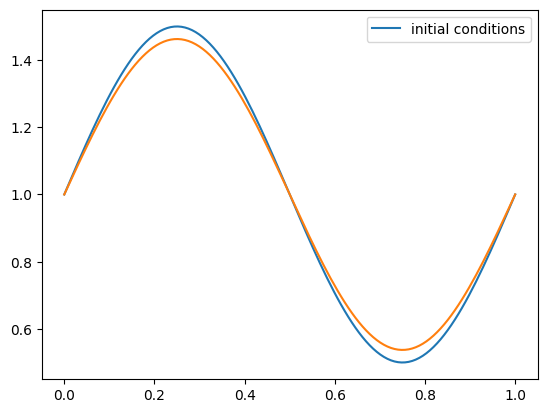

In [6]:
g = upwind_advection(nx, u, C, init_cond=sine)
fig = g.plot()

An error function that computes the L2-norm:

In [7]:
def error(g):
    err = 0.0
    for i in range(g.ilo, g.ihi+1):
        err += (g.a[i] - g.ainit[i])**2
        
    err /= g.nx
    return np.sqrt(err)

Now let's run at a bunch of resolutions and see how the error changes

In [8]:
u = 1.0
C = 0.5

for nx in [32, 64, 128, 256]:
    g = upwind_advection(nx, u, C, init_cond=sine)
    print(f"{nx:3d} {error(g):7.4f}")

 32  0.0950
 64  0.0509
128  0.0263
256  0.0134


As we see, this is demonstrating first-order convergence&mdash;as we double the number of cells, the error is decreasing by a factor of 2.